## Explore Piece Classification Results

A 13xN grid of classified training data.

N is the minimum number of examples predicted by the model on the current batch. 
(Discover if train_generator is very uneven.)


### Training data results

In [53]:
from square_classifier import build_square_classifier
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

num_classes = 13
batch_size = 300

# input image dimensions
input_shape = (64, 64, 1)

train_datagen = ImageDataGenerator(
        rescale=1./255
        )

# Class weighting
#https://stackoverflow.com/questions/44666910/keras-image-preprocessing-unbalanced-data
#https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
#train_datagen.fit()

train_generator = train_datagen.flow_from_directory(
        '../../data/squares_gen2',
        target_size=(64, 64),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

# Build the model
model = build_square_classifier()
model.load_weights("../../weights/best_weights_square.hdf5")

# Get a batch of training data
im_batch, _ = next(train_generator)

Found 6266 images belonging to 13 classes.


In [43]:
im_batch, _ = next(train_generator)

In [44]:
# Predict a batch & compute min 
from collections import Counter

label_names  = ['B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r', 'f']

class_probs = model.predict(im_batch)
predictions = np.argmax(class_probs, axis=1)
pred_labels = [label_names[p] for p in predictions]

# Get the minimum number of predictions for each class
counter = Counter(pred_labels)                          
num_sq = int(min(counter.values()))

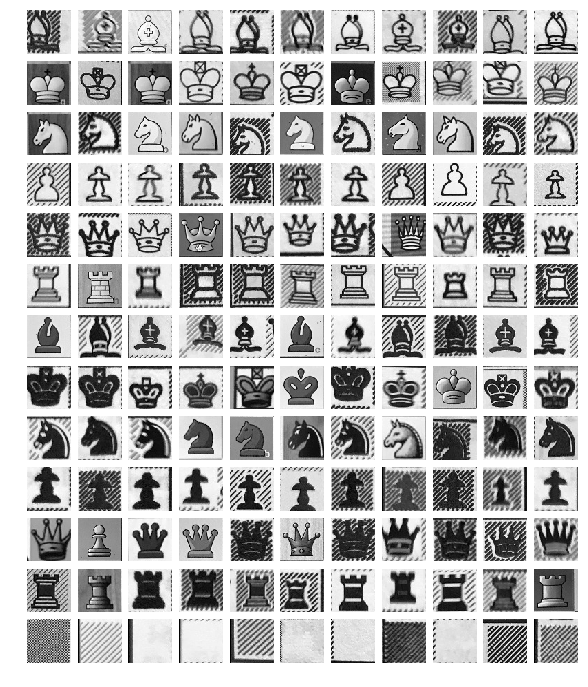

In [45]:
# Plot a grid of pieces

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

rows = num_classes
cols = num_sq

fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 label_mode=None
                 )

for i, class_name in enumerate(label_names):
    k = 0
    for j in range(cols):
        # get a new image from im_batch with pred_label class_name
        while pred_labels[k] != class_name:
            k += 1
        ax = grid[cols*i+j]
        ax.imshow(im_batch[k].reshape(64, 64), cmap="gray")
        ax.axis("off")
        k += 1

#plt.savefig("../../img/training_classification11.png", bbox_inches="tight")
plt.show()

### Test data results

- get batch of raw images (N=5)
- extract boards
- extract squares (N * 64) -> batch
- same as above: count min_sq and plot a grid

In [82]:
from util import listdir_nohidden
from board_extractor import extract_board
from extract_squares import extract_squares
import cv2 
import u_net as unet

num_boards = 15

raw_dir = "../../data/raw/"
raw_imgs = listdir_nohidden(raw_dir)
raw_batch = np.random.choice(raw_imgs, num_boards)

raw_imgs = list(map(lambda f: cv2.imread(raw_dir + f), raw_batch))
resized_imgs = list(map(lambda im: cv2.resize(im, (256, 256), interpolation=cv2.INTER_AREA), raw_imgs))

extract_model = unet.get_unet_256()
extract_model.load_weights('../../weights/best_weights.hdf5')


In [83]:
# build list of boards

boards = []
for raw_img, resized_img in zip(raw_imgs, resized_imgs):
    try:
        board = extract_board(resized_img, raw_img, extract_model)
    except Exception as e:
        print(e)
    boards.append(board)

# transform to a batch of squares
square_batch = []
for b in boards:
    squares, _ = extract_squares(b)
    square_batch.append(squares)

square_batch = np.array(square_batch)
square_batch = np.reshape(square_batch, (num_boards*64, 64, 64, 1))
print(square_batch.shape)

Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
(960, 64, 64, 1)


In [84]:
class_probs = model.predict(square_batch)
predictions = np.argmax(class_probs, axis=1)
pred_labels = [label_names[p] for p in predictions]

# Get the minimum number of predictions for each class
counter = Counter(pred_labels)                          
num_sq = int(min(counter.values()))

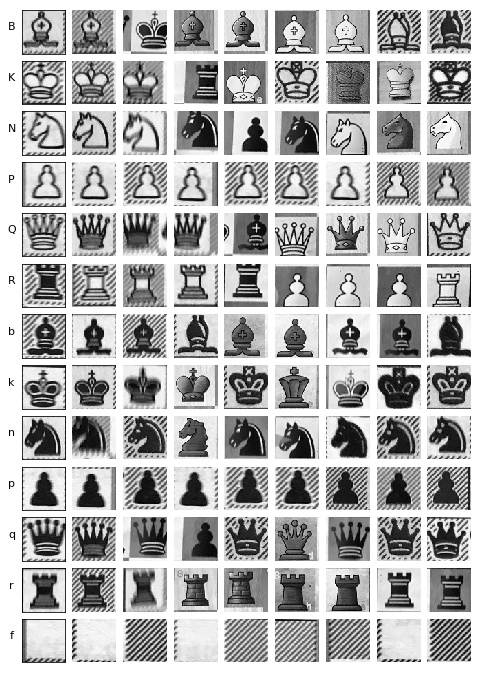

In [86]:

cols = num_sq
rows = num_classes

fig = plt.figure(2, figsize=(12, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 label_mode=None
                 )

for i, class_name in enumerate(label_names):
    k = 0
    for j in range(cols):
        # get a new image from im_batch with pred_label class_name
        while pred_labels[k] != class_name:
            k += 1
        ax = grid[cols*i+j]
        ax.imshow(square_batch[k].reshape(64, 64), cmap="gray")
        if j == 0:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylabel(class_name, rotation="horizontal", labelpad=10.0, size=11)
        else: 
            ax.axis("off")
            
        
        k += 1
#plt.suptitle("Classification of extracted boards from test set")
plt.savefig("../../img/test_classification.png", bbox_inches="tight")
plt.show()
